In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model

import tensorflow_addons as tfa

In [2]:
# A separate dataset for training a denoising network with fixed PSF and fixed noise
# Starting random seed for data generation 2314662
dataset = "../../data/data_v1a.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    noisy = data["img"]
    noiseless = data["img_nonoise"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma']


In [3]:
X = noisy[..., np.newaxis]
Y = noiseless[..., np.newaxis]

input_shape = X.shape[1:]
mean, std = X.mean(), X.std()


def normalize(x):
    return (x - mean) / std


def denormalize(x):
    return x * std + mean

In [4]:
def edsr(input_shape, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    x_in = Input(shape=input_shape)
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = Conv2D(1, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

In [5]:
model = edsr(input_shape)
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   640         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       conv2d[0][0]                     
_______________________________________________________________________________________________

In [6]:
# tf.keras.utils.plot_model(model)

In [7]:
# Setup callbacks. TQDM is used due to issues with the default progress bar on my TF2.1 installation.
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar()
checkpoint = tf.keras.callbacks.ModelCheckpoint("edsr.tf", save_best_only=True)

model.compile(optimizer="adam", loss="mae")
history = model.fit(
    X,
    Y,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    verbose=0,
    callbacks=[early_stopping, tqdm_callback, checkpoint],
)

Epoch 1/100



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 2/100



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 3/100



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 4/100



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 5/100



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 6/100



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 7/100



Epoch 8/100



Epoch 9/100



INFO:tensorflow:Assets written to: edsr.tf/assets
Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100


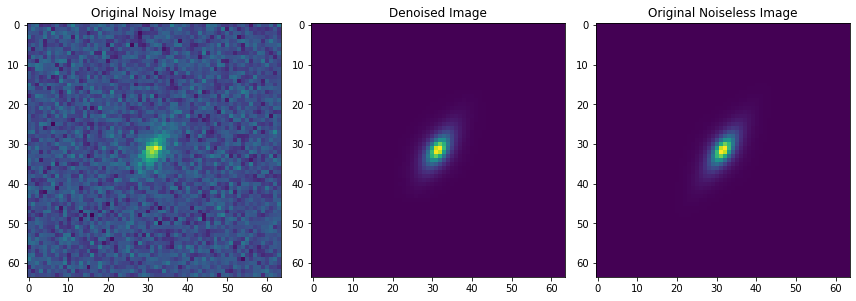

In [13]:
# Plot the results
pred = model.predict(X[np.newaxis, 0])[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
ax[0].imshow(X[0].reshape(64, 64))
ax[0].set_title("Original Noisy Image")
ax[1].imshow(pred.reshape(64, 64))
ax[1].set_title("Denoised Image")
ax[2].imshow(Y[0].reshape(64, 64))
ax[2].set_title("Original Noiseless Image");

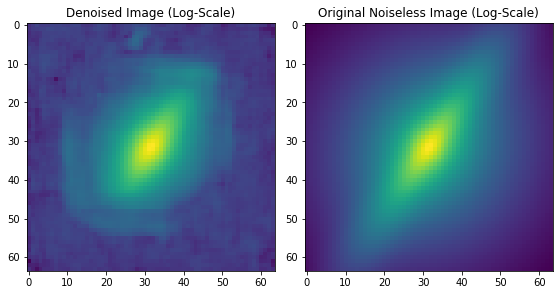

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax[0].imshow(np.log(pred).reshape(64, 64))
ax[0].set_title("Denoised Image (Log-Scale)")
ax[1].imshow(np.log(Y[0]).reshape(64, 64))
ax[1].set_title("Original Noiseless Image (Log-Scale)");

In [7]:
# Load the v1 dataset
dataset = "../../data/data_v1.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    noisy = data["img"]
    label = data["label"]
    psf_r = data["psf_r"]

X = noisy[..., np.newaxis]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma']


In [4]:
# Denoise the v1 dataset
model = tf.keras.models.load_model("edsr.tf")
pred = model.predict(X, batch_size=32, verbose=1)

200000/200000 [==============================] - 545s 3ms/sample


In [8]:
# Save the results
filename = "../../data/data_v1d.npz"
np.savez(
    filename, img_denoised=pred.reshape(-1, 64, 64), label=label, psf_r=psf_r,
)